* [Описание проекта](#Описание)
* [Исследовательский анализ данных EDA](#EDA)
   * [Столбчатые гисторграммы](#гисторграммы)
   * [Heatmap](#Heatmap)
* [Построение моделм прогнозирования оттока пользователей](#Построение)
* [Кластеризация пользователей](#Кластеризация)
* [Выводы](#Выводы) 

# Описание проекта <a id="Описание"></a> 

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что пользователь больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.
Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.А именно:

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
     - выделить целевые группы клиентов;
     - предложить меры по снижению оттока;
     - определить другие особенности взаимодействия с клиентами.



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv')

In [4]:
print(df.shape)
df.columns = df.columns.str.lower()
df.head() 

(4000, 14)


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


- 'Churn' — факт оттока в текущем месяце;
- Текущие поля в датасете:
    - Данные пользователя за предыдущий до проверки факта оттока месяц:
        - 'gender' — пол
        - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
        - 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
        - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
        - 'Phone' — наличие контактного телефона
        - 'Age' — возраст
        - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)
    - Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
        - 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
        - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
        - 'Group_visits' — факт посещения групповых занятий
        - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
        - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
        - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон


In [5]:
df.info() #all data is clean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

# Исследовательский анализ данных (EDA) <a id="EDA"></a> 


In [6]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


В среднем все спокойно - у нас примерно одинаковый разброс на мужчин и женщин и нет сильной разницы в возрасте. Есть интересный выброс в графе Lifetime - какой-то посетитель занимался в зале 31 месяц (почти 3 года), и в среднем зал посещают до 3 раз в неделю, за исключением человека, который приходит туда 6 дней из 7 с начала дейстия периода. 

In [7]:
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Мы видим, для churn = 0 (те, кто остался) присущи в среднем более взрслые люди (почти 30 лет), со средней частотой посещаяемости зала 2 раза в неделю на предыдущий месяц и являются клиентами зала уже 4 месяца. В большиестве случаев этот клиент получает партнерскую скидку от компании на посещение зала. Его контракт скорее всего на 6 месяцев. 
Напротив, клиент,котороый покинул зал churn = 1 более молодой в среднем 27 лет, является клиентом в среднем не больше 1 месяца и скорее всего взял аббонимент на 3 месяца. У него реже есть партнерская скидка от компании.

### Столбчатые гисторграммы <a id="гисторграммы"></a>

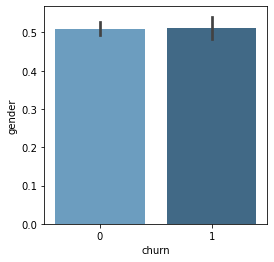

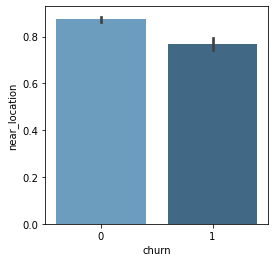

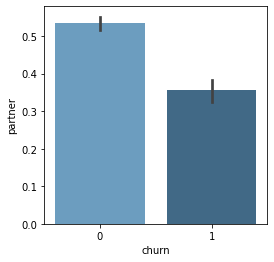

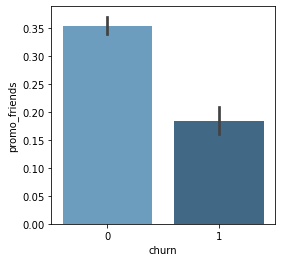

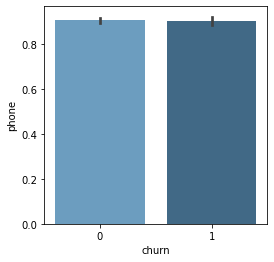

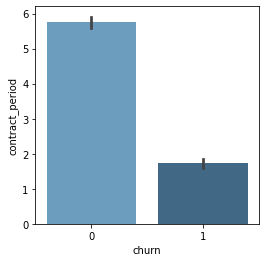

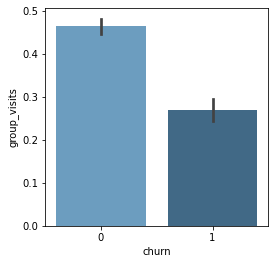

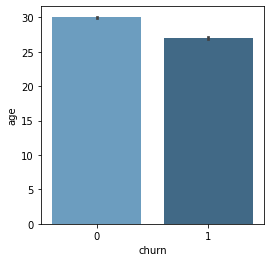

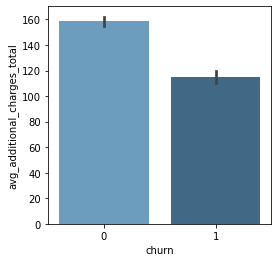

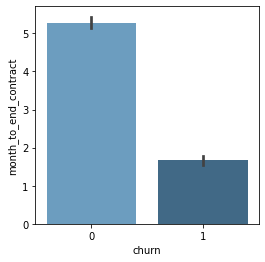

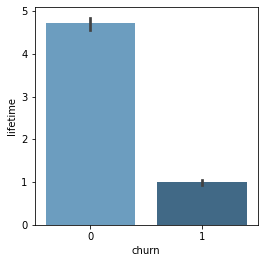

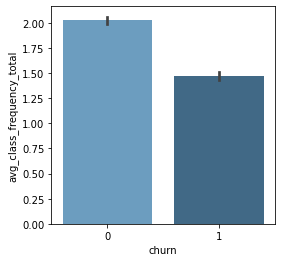

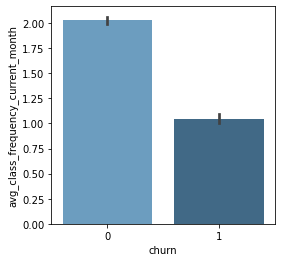

In [8]:
for col in df.drop('churn', axis = 1).columns: 
    plt.figure(figsize=(4, 4))
    sns.barplot(x="churn", y=col, data=df, palette="Blues_d")
    plt.show()

<AxesSubplot:xlabel='churn', ylabel='near_location'>

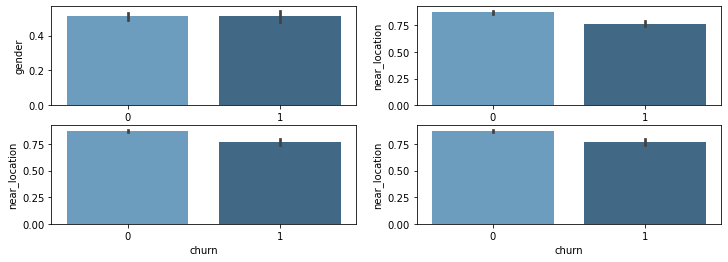

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12, 4))

sns.barplot(x="churn", y="gender", data=df, palette="Blues_d", ax=axs[0,0])
sns.barplot(x="churn", y="near_location", data=df, palette="Blues_d", ax=axs[0,1])
sns.barplot(x="churn", y="near_location", data=df, palette="Blues_d", ax=axs[1, 0])
sns.barplot(x="churn", y="near_location", data=df, palette="Blues_d", ax=axs[1, 1])

### Heatmap <a id="Heatmap"></a>


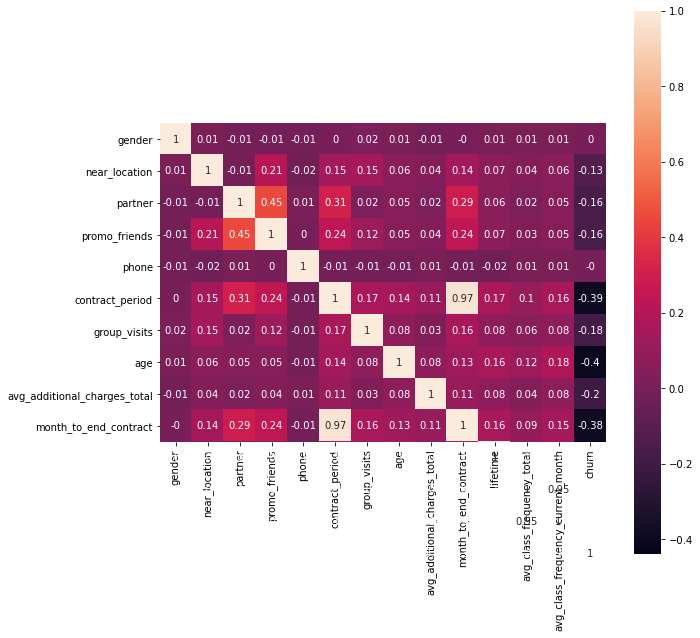

In [10]:
#построим и отрисуем матрицу корреляций
cm = df.corr().round(2) #вычисляем матрицу корреляций

#нарисуем тепловую карту с подписями для матрицы корреляций
f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cm, annot = True, square=True)#ваш код здесь
ax.set_ylim(
    10,0)
plt.show()

Больше всего связией с оттоком было выявлено в графах "month_to_end_contract", возраст и контрактный период. Напротив, гендер и наличие телефонного номера практически не влияют на процент отткока.
Клиенты, являющиеся частью программ "partner" и "group_visits" уходят реже, чем клиенты, не имеющие данной опции. Также, уходят чаще клиенты с более низким контактным периодом - вероятно, это был из пробный трехмесячный период и им что-то не понравилось, они решили не брать более долгосроный период (6 или 12 месяцев) и их lifetime, соответсвенно, значительно ниже.  

# Построение моделм прогнозирования оттока пользователей <a id="Построение"></a>

In [11]:
X = df.drop('churn', axis = 1)
y = df['churn']

#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

print(X_train_st[:5])

#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)


[[ 0.98080911  0.43135108 -0.97591496 -0.66881157  0.33159449 -0.82418932
   1.20114449  1.77316337 -1.20196914 -0.80771337  0.85637924  0.43543737
   0.52596665]
 [-1.01956639  0.43135108 -0.97591496 -0.66881157 -3.01573162  0.27226276
   1.20114449  1.77316337 -0.79944675 -0.56931799 -0.72447659  0.7997597
   0.91688153]
 [-1.01956639  0.43135108 -0.97591496 -0.66881157 -3.01573162  0.27226276
   1.20114449  0.85566386  0.84643939  0.38426357 -0.19752464 -0.25742006
  -0.3924693 ]
 [ 0.98080911 -2.31829722  1.02467945 -0.66881157  0.33159449 -0.82418932
  -0.8325393  -0.67350198  1.22590894 -0.80771337 -0.72447659 -0.30249034
  -1.61126587]
 [-1.01956639  0.43135108 -0.97591496 -0.66881157  0.33159449 -0.82418932
  -0.8325393   0.85566386  0.69801467 -0.80771337 -0.46100061  0.29982191
   0.24336719]]


In [12]:
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.83
	Recall: 0.81


In [13]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)  # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st) # Ваш код здесь
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]# Ваш код здесь
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.81
	Recall: 0.77


Видим, что Логистичекая регрессия ведет себя лучше по всем показателям (Accuracy, Precision и Recall)

# Кластеризация пользователей <a id="Кластеризация"></a>

# Шаг 4. Сделайте кластеризацию пользователей

    Отложите в сторону столбец с оттоком и проведите кластеризацию объектов (пользователей):
        Стандартизируйте данные.
        Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. Внимание: отрисовка дендрограммы может занять время! На основании полученного графика предположите, какое количество кластеров можно выделить.
        Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта).
        Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
        Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?
        Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по д

In [14]:
sc = StandardScaler()
X_sc = sc.fit_transform(df)

linked = linkage(X_sc, method = 'ward') 

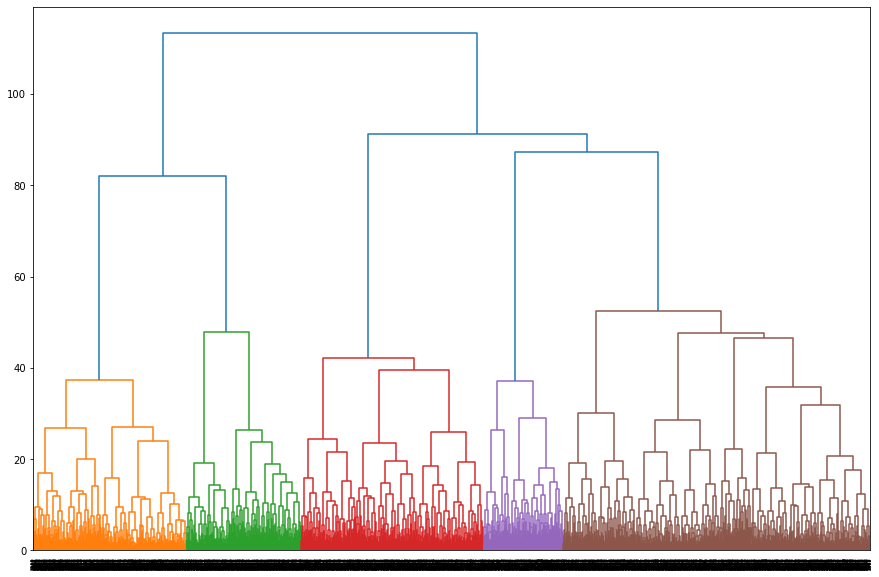

In [15]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 
#Предложенное оптимальное число кластеров 5 — пять разных цветов на графике.

In [16]:
km = KMeans(n_clusters = 5, random_state = 0) # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров 

df['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
df.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.503676,0.000000,0.459559,0.075368,0.917279,2.069853,0.211397,28.522059,132.741216,1.950368,2.757353,1.706629,1.515890,0.450368
1,0.492829,0.936115,0.764016,0.534550,0.919166,10.447197,0.516297,29.962190,161.853561,9.477184,4.833116,2.788103,2.786919,0.007823
2,0.507917,1.000000,0.323995,0.213155,0.903776,1.546894,0.287454,26.926918,113.173051,1.500609,1.031669,1.449720,1.037592,0.961023
3,0.521186,0.996610,0.282203,0.208475,0.904237,1.882203,0.452542,30.237288,157.988625,1.794915,4.923729,2.203432,2.207359,0.003390
4,0.518895,0.968023,0.744186,0.526163,0.873547,8.859012,0.534884,29.728198,162.907495,8.155523,4.411337,0.957744,0.943967,0.024709


Кластелизировав данные, можно заметить, что те, кто ходят на групповые занятия так же являются обладателями Promo_friends и имеют самый длинный контракт в среднем. Самая низкая доля оттока у того кластера,который посещает зал в среднем 2 раза в неделю и имеет самый длинный lifetime (время с момента первого обращения в фитнес-центр). Те, у кого выше всех процесс оттока меньше всех посещают зал и их lifetime самый низкий, также они моложе всех других кластеров.

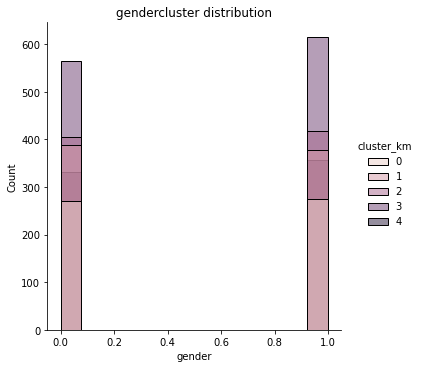

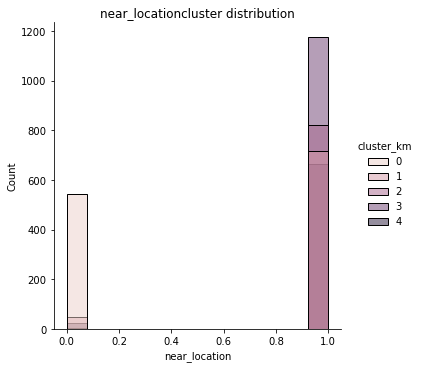

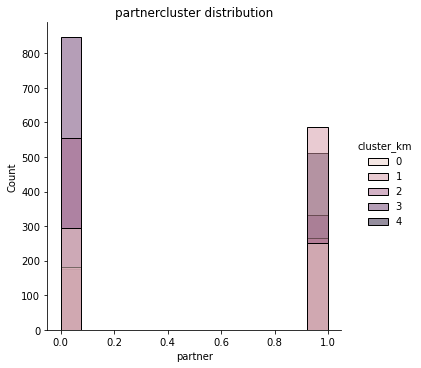

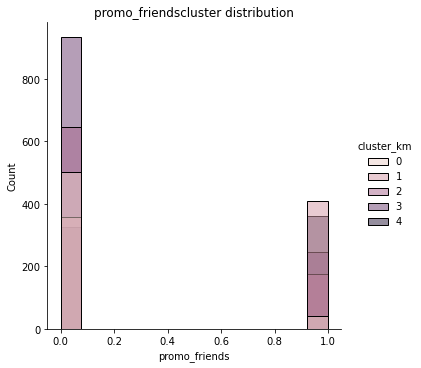

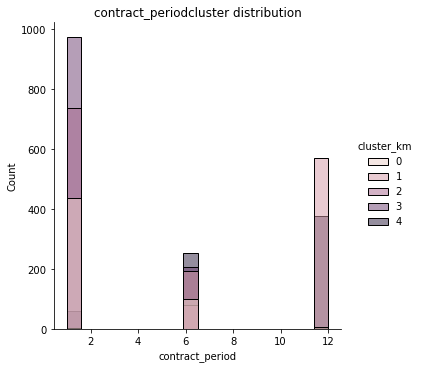

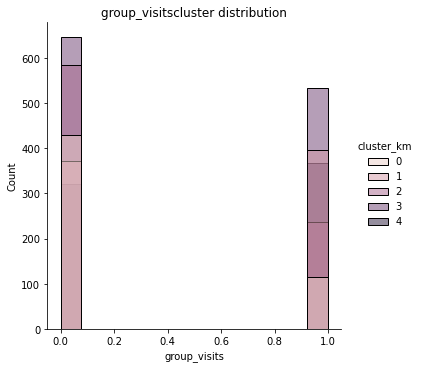

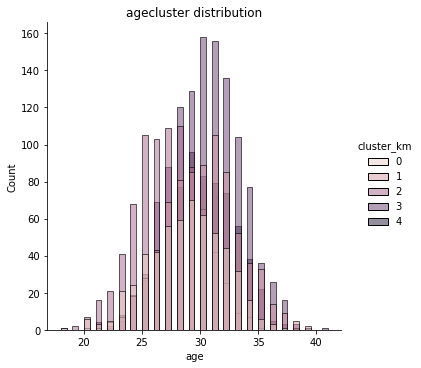

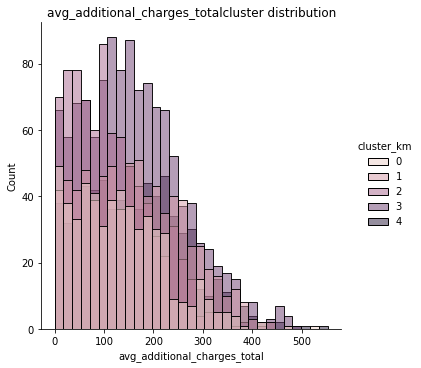

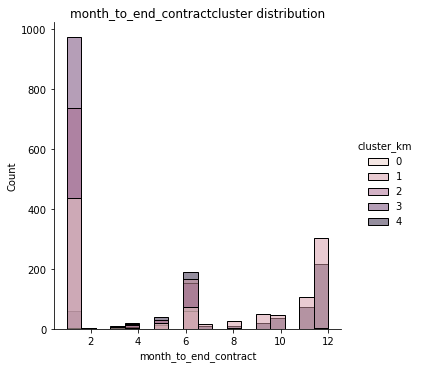

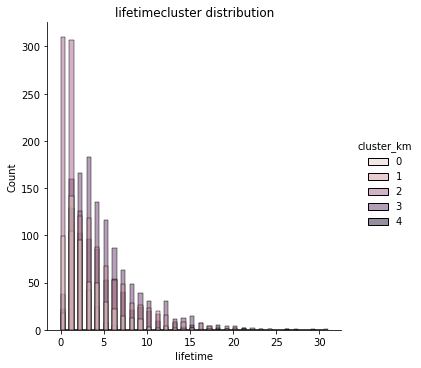

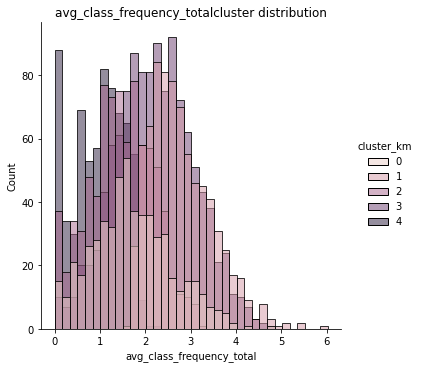

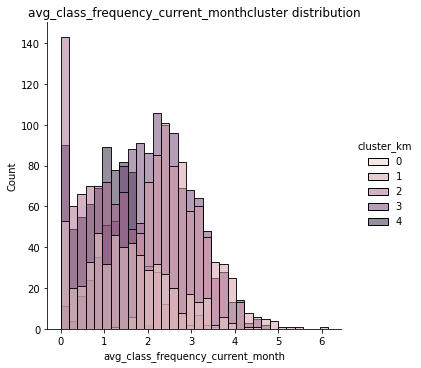

In [18]:
for col in df.drop(['churn','phone', 'cluster_km'], axis=1):
    sns.displot(x = df[col], hue = df['cluster_km'])
    plt.title(col + 'cluster distribution')
    plt.show()

# Выводы <a id="Выводы"></a>

После проведения эксперимета, было выявлено, что использование модели Логистическоей регресси является самым разумным - ее метрики заметно лучше справляется с точностью выполнения задачи, в отличие от метрик Случайного леса. Решение было принято на основе метрик Accuracy, Precision и Recall

Выжные принципы:
- Для удержания клиентов можно каким-либо образом заставить их посещать зал больше 1-ого раза в неделю. Например, давать опреденные бонусы или скидку для тех, кто посетит зал больше условных 9-10 раз в месяц. Скажем, при посещении зала от 10-ти раз в месяц день выдается скидка на покупку нового(трех/полуодового абонимента) абонимента. В среднем для тех, кто посещает зал примерно два раза в неделю, lifetime был выше
- Если мы хотим увеличить чисто пользователей с более долгосроным абониментом, мы можем более активно рекламировать программу Promo_friends. Было выявлено, что приглашенные друзья чаще занимаются в групповых занятиях и их контракт один их самых длинных в среднем.
- Также было выявлено, что низший процент оттока у клиентов,входящих в графу "Partner" — сотрудник компании-партнёра клуба. В таком случае мы могли бы увеличить количество компаний, входящих в данную область. Они же, к слову, чаще всех являются частью акции "promo_friends", а значит, заниматься с коллегами-друзьями в зале приятнее, чем одному и увеличивает количество посещений клиента. Они же, видимо, более удовлетворены продукцией зала - их покупательская способность выше всех.
- Клиенты с более коротким контрактом уходят чаще, чем клиенты с более длинным контактом. В таком случае, можно уменьшить разницу в цене и сделать шестимесяный период более выгодным для приобретеия. В таком случае у клиента будет больше времени для возврашеия в зал, если абонимет изначально более длинный.

* [Описание проекта](#Описание)
* [Исследовательский анализ данных EDA](#EDA)
   * [Столбчатые гисторграммы](#гисторграммы)
   * [Heatmap](#Heatmap)
* [Построение моделм прогнозирования оттока пользователей](#Построение)
* [Кластеризация пользователей](#Кластеризация)
* [Выводы](#Выводы) 